## Установка библиотек

In [10]:
!pip install mediapipe opencv-python

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

In [63]:
!pip install plotly
import plotly.graph_objects as go
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.6 MB 2.0 MB/s eta 0:00:08
   ---------------------------------------- 0.2/15.6 MB 2.4 MB/s eta 0:00:07
   - -------------------------------------- 0.5/15.6 MB 3.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/15.6 MB 4.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.3/15.6 MB 5.9 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/15.6 MB 5.6 MB/s eta 0:00:03
   ----- ---------------------------------- 2.0/15.6 MB 6.2 MB/s eta 0:00:03
   ----- ---------------------------------- 2.1/15.6 MB 6.3 MB/s eta 0:00:03
   ------ --------------------------------- 2.7/15.6 MB 6.6 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/15.6 MB 6.6 MB/s eta 0:00:02
   -------- --

In [89]:
import math
import plotly.express as px
from pathlib import Path
import cv2
import mediapipe as mp
import csv
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Функция вывода позы

In [90]:
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

In [97]:
def plot_landmarks(landmark_list, connections=None,):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        print('connections')
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )

    return fig

## Визуализация картинки

In [120]:
# Получение списка всех файлов в директории
isRandom = False
images_directory = r"D:\UII\Stazhirovka_4_Karate\All Pictures for learn\KidzamiDzuki_Side_Udar_True"
image_files = [f for f in os.listdir(images_directory) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]

# Выбор случайного файла изображения
random_image = random.choice(image_files)

# Формирование полного пути к выбранному случайному файлу изображения
image_path = os.path.join(images_directory, random_image)

if isRandom == False:
    image_path=r"D:\UII\Stazhirovka_4_Karate\All Pictures for learn\MG_Side_Udar\MavashiGeri_AndreySide_True_000205.jpg"

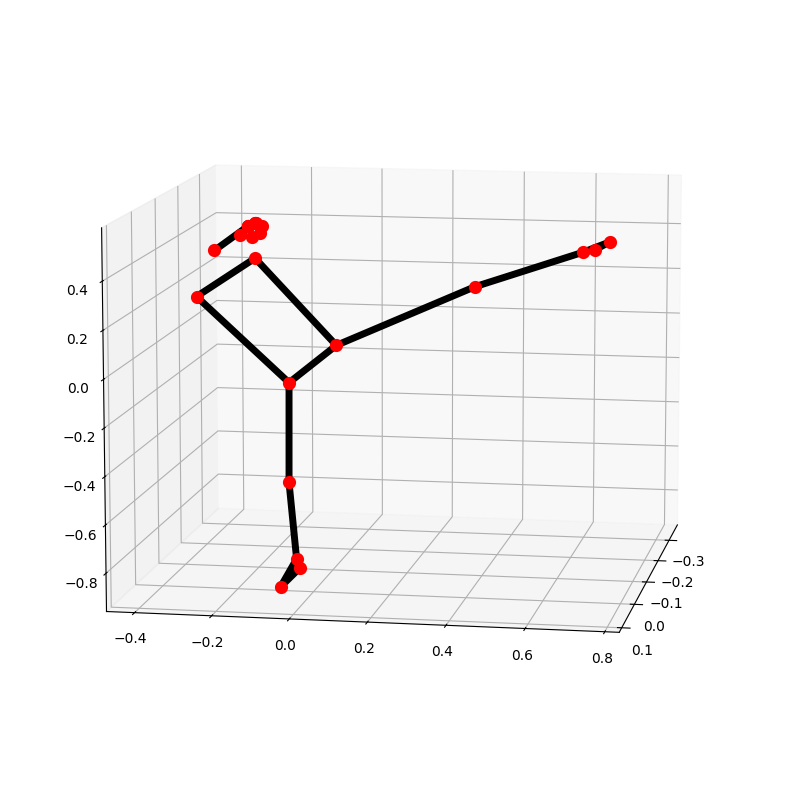

In [122]:
# Загрузка изображения
image = cv2.imread(image_path)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Проверка, успешно ли загружено изображение
    if image is not None:
        # Recolor Feed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = holistic.process(image)
        
            
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )  
        window_height = 600
        # Вычисление новых размеров изображения
        aspect_ratio = image.shape[1] / image.shape[0]
        new_width = int(window_height * aspect_ratio)

        # Изменение размера изображения
        resized_image = cv2.resize(image, (new_width, window_height))
        mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)

        
        # # Отображение изображения
        # cv2.imshow('Image', resized_image)
        # # Ожидание нажатия клавиши
        # cv2.waitKey(0)
        # # Закрытие окна после нажатия клавиши
        # cv2.destroyAllWindows()
    

    else:
        print("Не удалось загрузить изображение.")

## Визуализация строки CSV

In [103]:
df_Pavel = pd.read_csv("coords_world.csv")
X_full = df_Pavel.drop(['class'], axis=1) # features
X_full.head()

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,-0.134079,-0.626747,-0.257024,0.999872,-0.118795,-0.664419,-0.255716,0.999797,-0.118401,-0.664839,...,0.411395,0.777677,0.155517,0.838480,-0.263793,0.991872,-0.126985,0.731248,0.362951,0.900365
1,-0.189615,-0.627241,-0.175139,0.999061,-0.175179,-0.664113,-0.191981,0.999070,-0.174704,-0.664521,...,0.523364,0.678756,0.139700,0.814611,-0.296799,0.994237,-0.203454,0.695877,0.483123,0.889777
2,-0.180336,-0.613076,-0.235089,0.999767,-0.169984,-0.650715,-0.239803,0.999776,-0.169521,-0.651157,...,0.498463,0.569508,0.116261,0.823982,-0.263725,0.990856,-0.133374,0.633084,0.465662,0.758769
3,-0.199957,-0.611474,-0.223876,0.999433,-0.191610,-0.650099,-0.232658,0.999408,-0.191344,-0.650476,...,0.610215,0.446618,0.104512,0.800534,-0.370729,0.990775,-0.222299,0.631982,0.557851,0.727876
4,-0.201504,-0.618600,-0.181240,0.998808,-0.193228,-0.656667,-0.194940,0.998682,-0.193001,-0.657033,...,0.606100,0.462813,0.097921,0.809596,-0.424439,0.992796,-0.218858,0.650579,0.549978,0.768792


In [126]:
LINE_NUMBER = 153

In [127]:
from mediapipe.framework.formats import landmark_pb2

# Ваш плоский список координат
#pose_row = [0.1, 0.2, 0.3, 0.8, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1]
selected_row = X_full.iloc[LINE_NUMBER]
# Разбиваем плоский список на группы по 4 значения (x, y, z, visibility)
pose_chunks = [selected_row[i:i+4] for i in range(0, len(selected_row), 4)]

# Создаем объект pose_world_landmarks и заполняем его значениями
world_landmarks = landmark_pb2.NormalizedLandmarkList()
for chunk in pose_chunks:
    landmark = world_landmarks.landmark.add()
    landmark.x, landmark.y, landmark.z, landmark.visibility = chunk

# Теперь переменная results содержит данные в формате pose_world_landmarks
print(world_landmarks)

landmark {
  x: 0.16130967438220978
  y: -0.6433069109916687
  z: -0.11021215468645096
  visibility: 0.9999558925628662
}
landmark {
  x: 0.1300717294216156
  y: -0.6873703598976135
  z: -0.09289106726646423
  visibility: 0.9997993111610413
}
landmark {
  x: 0.13056810200214386
  y: -0.687586784362793
  z: -0.09188161790370941
  visibility: 0.9997578263282776
}
landmark {
  x: 0.13066713511943817
  y: -0.6880636215209961
  z: -0.09186172485351562
  visibility: 0.999774158000946
}
landmark {
  x: 0.11990305781364441
  y: -0.6764233112335205
  z: -0.12360452115535736
  visibility: 0.999906063079834
}
landmark {
  x: 0.12058509141206741
  y: -0.6771274209022522
  z: -0.1244901791214943
  visibility: 0.9998921155929565
}
landmark {
  x: 0.12054336816072464
  y: -0.6784776449203491
  z: -0.12369164079427719
  visibility: 0.9998608827590942
}
landmark {
  x: 0.028122326359152794
  y: -0.6854193210601807
  z: 0.002946237800642848
  visibility: 0.999381422996521
}
landmark {
  x: -0.0129539575

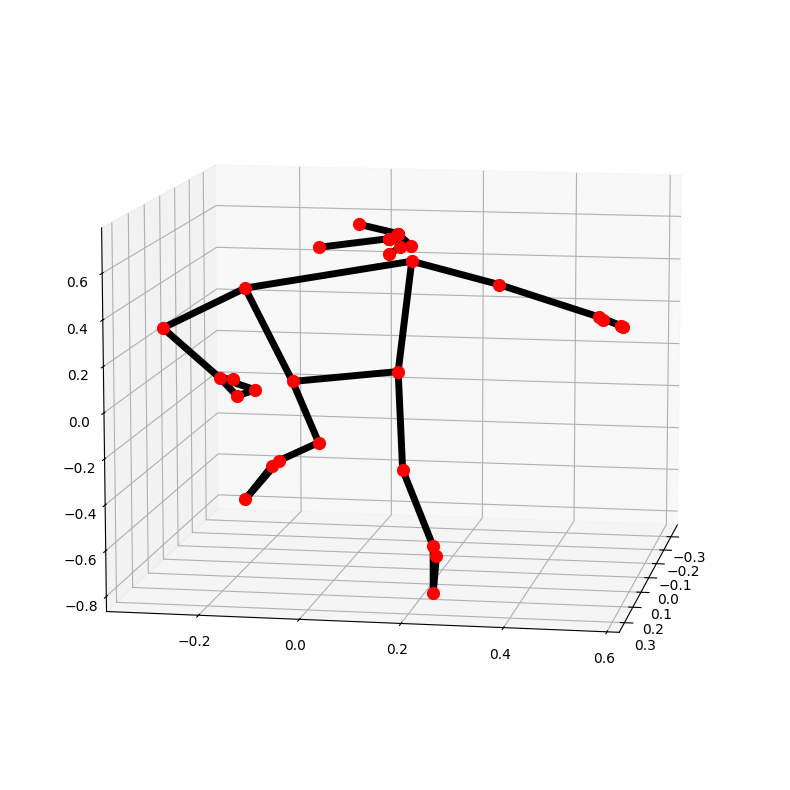

In [125]:
mp_drawing.plot_landmarks(world_landmarks,  mp_pose.POSE_CONNECTIONS)